In [ ]:
pip install opencv-python numpy matplotlib scikit-image tensorflow fiftyone kaggle


In [ ]:
pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 119.7 kB/s eta 0:00:00a 0:00:03
  Attempting uninstall: pip
    Found existing installation: pip 25.0
    Uninstalling pip-25.0:
      Successfully uninstalled pip-25.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
# For GPU users
!pip install tensorflow[and-cuda]


  Using cached nvidia_cublas_cu12-12.5.3.2-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.5.82-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvcc_cu12-12.5.82-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.5.82-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.5.82-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cudnn_cu12-9.3.0.75-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu12-11.2.3.61-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.6.82-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.3.83-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.5.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-

In [7]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2025-03-13 18:00:20.721041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741869020.816389    2313 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741869020.849435    2313 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 18:00:21.095154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import save_model, load_model
import joblib
import pandas as pd

In [9]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
IMAGE_SIZE = (224, 224)
KMEANS_MODEL_PATH = "unified_kmeans_model.pkl"
EFFICIENTNET_MODEL_PATH = "efficientnet_b0_feature_extractor.h5"
METRICS_FILE = "performance_metrics.csv"

##Feature Extraction

In [11]:
class FeatureExtractor:
    def __init__(self):
        self.model = EfficientNetB0(weights="imagenet", include_top=False, pooling='avg')
        self.extraction_times = []
        self.memory_usage = []

    def extract_features(self, image_path):
        """Extract features with resource monitoring"""
        process = psutil.Process(os.getpid())
        start_time = time.time()

        try:
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Image at {image_path} could not be loaded.")

            image_resized = cv2.resize(image, IMAGE_SIZE)
            image_preprocessed = preprocess_input(image_resized)
            features = self.model.predict(np.expand_dims(image_preprocessed, axis=0))

            # Record metrics
            self.extraction_times.append(time.time() - start_time)
            self.memory_usage.append(process.memory_info().rss / (1024 ** 2))  # MB
            return features.flatten()

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None


##K-means training and metrics

In [12]:
def train_unified_kmeans(input_folder, k=3):
    """Train model with comprehensive metrics tracking"""
    extractor = FeatureExtractor()
    all_features = []
    valid_files = 0

    # Feature extraction phase
    for filename in os.listdir(input_folder):
        if filename.lower().endswith((".jpg", ".png", ".jpeg")):
            image_path = os.path.join(input_folder, filename)
            features = extractor.extract_features(image_path)
            if features is not None:
                all_features.append(features)
                valid_files += 1

    # Clustering phase
    clustering_start = time.time()
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(all_features)
    clustering_time = time.time() - clustering_start

    # Calculate performance metrics
    metrics = {
        "timestamp": pd.Timestamp.now(),
        "num_images": valid_files,
        "avg_extraction_time": np.mean(extractor.extraction_times),
        "max_extraction_time": np.max(extractor.extraction_times),
        "total_extraction_time": np.sum(extractor.extraction_times),
        "avg_memory_usage": np.mean(extractor.memory_usage),
        "peak_memory": np.max(extractor.memory_usage),
        "clustering_time": clustering_time,
        "silhouette": silhouette_score(all_features, kmeans.labels_),
        "davies_bouldin": davies_bouldin_score(all_features, kmeans.labels_),
        "calinski_harabasz": calinski_harabasz_score(all_features, kmeans.labels_)
    }

    # Save models and metrics
    joblib.dump(kmeans, KMEANS_MODEL_PATH)
    save_model(extractor.model, EFFICIENTNET_MODEL_PATH)
    save_metrics_to_csv(metrics)

    return kmeans, metrics


In [13]:
def save_metrics_to_csv(metrics):
    """Save metrics to CSV file for historical tracking"""
    df = pd.DataFrame([metrics])
    file_exists = os.path.isfile(METRICS_FILE)

    if not file_exists:
        df.to_csv(METRICS_FILE, index=False)
    else:
        df.to_csv(METRICS_FILE, mode='a', header=False, index=False)


In [14]:
def visualize_metrics_history():
    """Visualize historical performance metrics"""
    try:
        df = pd.read_csv(METRICS_FILE)
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        plt.figure(figsize=(15, 10))

        # Time metrics
        plt.subplot(2, 2, 1)
        plt.plot(df['timestamp'], df['avg_extraction_time'], label='Avg Extraction')
        plt.plot(df['timestamp'], df['clustering_time'], label='Clustering')
        plt.ylabel('Time (seconds)')
        plt.title('Processing Times')
        plt.legend()

        # Memory metrics
        plt.subplot(2, 2, 2)
        plt.plot(df['timestamp'], df['peak_memory'], 'r-', label='Peak Memory')
        plt.ylabel('Memory (MB)')
        plt.title('Memory Usage')
        plt.legend()

        # Clustering quality
        plt.subplot(2, 2, 3)
        plt.plot(df['timestamp'], df['silhouette'], label='Silhouette')
        plt.plot(df['timestamp'], df['calinski_harabasz'], label='Calinski-Harabasz')
        plt.ylabel('Score')
        plt.title('Clustering Quality')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(df['timestamp'], df['davies_bouldin'], 'g-', label='Davies-Bouldin')
        plt.ylabel('Score')
        plt.title('Cluster Separation')
        plt.legend()

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print("No historical metrics found")


In [15]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━


Current Training Metrics:
           timestamp: 2025-03-13 19:05:14.777773
          num_images: 15520
 avg_extraction_time: 0.0918
 max_extraction_time: 4.449
total_extraction_time: 1424.0331
    avg_memory_usage: 1860.6535
         peak_memory: 1914.9258
     clustering_time: 3.9399
          silhouette: 0.06331135332584381
      davies_bouldin: 4.2949
   calinski_harabasz: 907.9024047851562


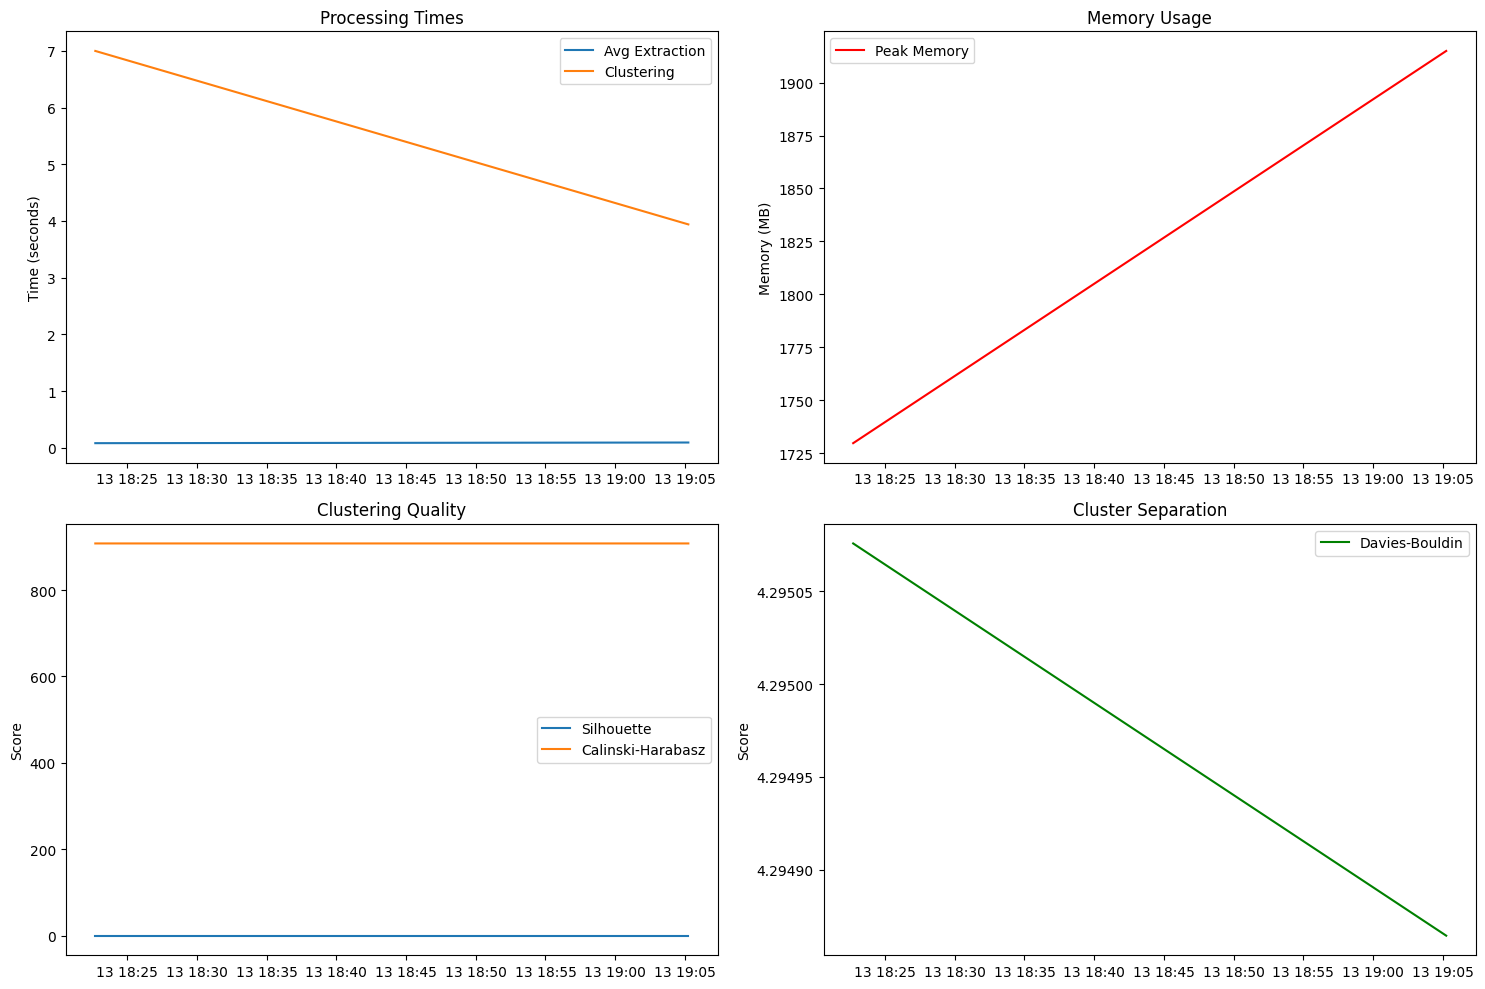

In [17]:
if __name__ == "__main__":
    # Train model with metrics tracking
    input_folder = "/home/sala/iit/dsgp/preprocessed_data/general_data/"
    kmeans_model, metrics = train_unified_kmeans(input_folder, k=3)

    print("\nCurrent Training Metrics:")
    for k, v in metrics.items():
        if k == "timestamp":
            print(f"{k:>20}: {v}")
        else:
            print(f"{k:>20}: {round(v, 4) if isinstance(v, (int, float)) else v}")
    
    # Visualize historical trends
    visualize_metrics_history()
    
    # Sample prediction
    # efficientnet_model = load_model(EFFICIENTNET_MODEL_PATH)
    # test_image = "path/to/test_image.jpg"
    # dominant_color = predict_dominant_color(test_image, kmeans_model, efficientnet_model)
    # visualize_results(test_image, dominant_color)


<!--  -->